In [54]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [55]:
!pip install lightgbm

In [56]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [57]:
## librerias requeridas
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
#from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
#from scikitplot.metrics import plot_lift_curve
#from scikitplot.helpers import binary_ks_curve 
#from scikitplot.metrics import plot_ks_statistic
#from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [58]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Cargo el modelo y los datos a los que lo voy a aplicar 

In [59]:
import os
os.getcwd()

'/home/ec2-user/SageMaker/viamericas-dev/Analytics/5.Fraud'

In [60]:
import os
import joblib
# load model
#modelo = joblib.load("Analytics/5.Fraud/ModeloV1Todos.pkl") 
modelo = joblib.load("ModeloV2Todos.pkl") 
##ModeloV1T1

In [61]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

In [62]:
# Veo si puedo sacar los nombres directo del modelo q cargue
var_input = ['01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', 
         '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', 
         '01_sender_days_to_last_transaction_365', 'sender_days_to_last_transaction_more365',
        'id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 
         'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X']

var_input = ['01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', 
         '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', 
         '01_sender_days_to_last_transaction_365', 'day_name_receiver_Friday', 'day_name_receiver_Monday', 
         'day_name_receiver_Saturday', 'day_name_receiver_Sunday', 'day_name_receiver_Thursday', 'day_name_receiver_Tuesday', 
         'day_name_receiver_Wednesday','id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 
         'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X',
         '01_isMexico','tx_brancity', 'tx_brancity_total', 'ptx_brancity','idlocation_fraud']

var_input = ['01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', 
         '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', 
         '01_sender_days_to_last_transaction_365', 'sender_days_to_last_transaction_more365',
        'id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 
         'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X']

In [63]:
var_input = [ 'branch_trans_3m', 'count_date_receiver_distinct','branch_has_fraud',
       'receiver_has_fraud',
       'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_4min',
       'location_nro_fraud', 'sender_trans_3m',
       'sender_nro_fraud', '01_isMexico',
       '01_sender_branch_state', '01_Var_range_hist', '01_receiver_fraud',
       '01_branch_fraud', '01_location_fraud', '01_sender_fraud',
       '01_isCashPick', '01_isBankDep',
       'sender_days_to_last_transaction_more365',
       'sender_days_to_last_transaction_more7m',
       '01_receiver_transaction_count', '01_sender_sending_days',
       '01_branch_working_days', '01_net_amount_receiver',
       '01_sender_minutes_since_last_transaction_2days',
       '01_sender_minutes_since_last_transaction_1day',
       '01_sender_days_to_last_transaction_365',
       '01_sender_days_to_last_transaction_7m', '01_hour_receiver',
       'day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6']

In [64]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Uni test y Val
X = pd.concat([dfTrain[var_input], dfVal[var_input]], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

testeo =  pd.concat([X, Y], axis=1)

In [65]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

##lista de variables de input
X = tes[var_input]
Y = tes[['target']]
dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

#testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
#Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target], tes[dias_target]], ignore_index=True)) 
testeo =  tes.copy()
Y_target = pd.DataFrame(tes[dias_target]) 

In [66]:
Y_target

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target
0,False,False,False,False,False,False,True,False
1,False,False,False,False,False,True,False,False
2,True,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...
9754069,False,False,False,True,False,False,False,False
9754070,False,True,False,False,False,False,False,False
9754071,False,False,False,False,True,False,False,False
9754072,False,False,False,False,False,False,True,False


In [67]:
## Evaluo los resultados

# Veo si puedo sacar los nombres directo del modelo q cargue
var_input = ['01_receiver_transaction_count', '01_sender_sending_days', '01_branch_working_days', '01_net_amount_receiver', 
         '01_sender_minutes_since_last_transaction_2days', '01_sender_minutes_since_last_transaction_1day', 
         '01_sender_days_to_last_transaction_365', 'sender_days_to_last_transaction_more365',
        'id_payout_A', 'id_payout_C', 'id_payout_D', 'id_payout_M', 'id_payout_N', 'id_payout_O', 
         'id_payout_P', 'id_payout_S', 'id_payout_T', 'id_payout_X']

In [68]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [69]:
testeo['target'].value_counts(dropna=False)

target
False    9753910
True         164
Name: count, dtype: int64

In [70]:
# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = modelo.predict_proba(testeo[var_input])

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [71]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_c = Y_target.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_c['score_rf'] = score_rf

In [72]:
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['preds_rf']))

,0,1
0,9753907,3
1,157,7


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='score_rf', ylabel='Count'>

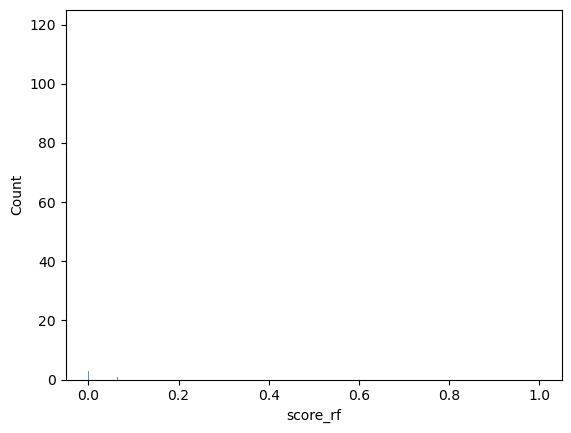

In [73]:
import seaborn as sns
sns.histplot(data = Y_c[Y_c['target'] == True], x='score_rf')

In [74]:
# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=100, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')
print('FRAUD CAPTURA 30%:')
print(sum(Y_c[Y_c['FRAUD_DECILE'] < 4]['target']) / sum(Y_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')

FRAUD CAPTURA 30%:
0.8902439024390244


In [75]:
DECILES = pd.crosstab(Y_c['FRAUD_DECILE'], Y_c['target'])
DECILES

target,False,True
FRAUD_DECILE,,
1,97407,134
2,97532,9
3,97538,3
4,97537,3
5,97539,2
...,...,...
96,97541,0
97,97540,0
98,97541,0


array([<Axes: title={'center': 'False'}, xlabel='FRAUD_DECILE'>,
       <Axes: title={'center': 'True'}, xlabel='FRAUD_DECILE'>],
      dtype=object)

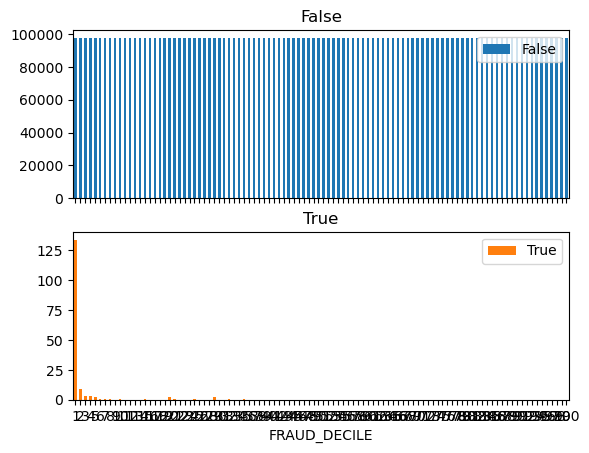

In [76]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)

In [77]:
#saco el punto de corte del primer centil para aplicarlo al test
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
Y_c[['score_rf','FRAUD_DECILE']].groupby(['FRAUD_DECILE']).agg({'score_rf': [ 'min', 'max']}) 

score_rf              
                       min           max
FRAUD_DECILE                            
1             1.665949e-08  9.999992e-01
2             4.276835e-09  1.665930e-08
3             1.955988e-09  4.276769e-09
4             1.123434e-09  1.955974e-09
5             7.303399e-10  1.123423e-09
...                    ...           ...
96            1.164534e-13  1.416892e-13
97            9.170117e-14  1.164533e-13
98            6.688236e-14  9.170114e-14
99            4.060743e-14  6.688229e-14
100           1.544227e-15  4.060737e-14

[100 rows x 2 columns]

In [78]:
Y_c[['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6',
     'FRAUD_DECILE']].groupby(['FRAUD_DECILE']).sum()

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6
FRAUD_DECILE,,,,,,,
1,11600,15321,15418,12992,7305,18920,15985
2,11666,14923,15257,12993,7561,19261,15880
3,12328,14779,14789,12394,7905,19532,15814
4,12383,14419,14340,12220,8287,19880,16011
5,12559,14388,14150,12140,8344,19866,16094
...,...,...,...,...,...,...,...
96,8973,6342,5235,7085,29957,20483,19466
97,8879,6101,4974,6881,29975,20941,19789
98,8359,5752,4626,6707,29313,21772,21012
